In [1]:
from utils.all import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('fivethirtyeight')
five_thrity_eight=[
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",    
]
sns.set_palette(five_thrity_eight)
import pydata_google_auth
import datetime as dt
!pip3 install lifelines --quiet
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

In [222]:
sql="""
SELECT  a.partner_position_id
,started_at
,b.*
FROM `uw-data-models-prod.partner_dataform_models_position.position` a

LEFT JOIN 
(SELECT* FROM `uw-data-models-prod.partner_dataform_models_position.onboarding_milestones` ) as b 
 ON a.partner_position_id = b.partner_position_id
 
#   WHERE date_diff(CURRENT_DATE(), CAST(started_at AS DATE ), DAY)<=90
 
WHERE started_at  >'2021-04-19'
"""
app_sql="""
WITH users AS (
    SELECT DISTINCT(partner_position_id) AS partner_position_id
    FROM `uw-data-models-prod.partner_dataform_models_partner_app_analytics.sessions`
    WHERE is_staff IS FALSE
)
SELECT users.*
FROM users
LEFT JOIN `uw-data-models-prod.partner_dataform_models_position.position` pos
ON users.partner_position_id = pos.partner_position_id
WHERE pos.started_at >= '2021-04-19'

"""

In [223]:
df=download_data(project_id='uw-data-warehouse-prod',query=sql)

Downloading:   0%|          | 0/1367 [00:00<?, ?rows/s]

In [174]:
app=download_data(project_id='uw-data-warehouse-prod',query=app_sql)

Downloading:   0%|          | 0/725 [00:00<?, ?rows/s]

In [224]:
df.drop(['partner_position_id_1'],axis=1,inplace=True)
df['started_at']=df.started_at.dt.date

In [225]:
# Cleanse datetime
date_cols=df.select_dtypes(include=['datetime']).columns.tolist()
date_cols.append('started_at')
for c in df[date_cols]:
    df[c]=pd.to_datetime(df[c])

In [226]:
survival_df=df[['partner_position_id','started_at','first_prospect_added_date','sixth_prospect_added_date','first_customer_gathered_excluding_self_date','first_gathered_six_personal_customers_date','verification_date','getting_started_online_completed_date']].copy()
survival_df=survival_df.drop(survival_df[survival_df.first_customer_gathered_excluding_self_date<survival_df.started_at].index,axis=0)

In [227]:
today_date=pd.to_datetime('2021-06-18')

In [228]:
for c in survival_df.columns[2:]:
    title=re.sub('_date','',c)
    survival_df.loc[:,'has_'+title]=np.where(survival_df[c].isnull(),0,1)

In [229]:
survival_df.fillna(today_date,inplace=True)

In [230]:
for c in survival_df.columns[2:8]:
    print(c)
    title=re.sub('_date','',c)
    survival_df.loc[:,'tenure_'+title]=abs(survival_df[c]-survival_df.started_at)

first_prospect_added_date
sixth_prospect_added_date
first_customer_gathered_excluding_self_date
first_gathered_six_personal_customers_date
verification_date
getting_started_online_completed_date


In [156]:
# for c in [c for c in survival_df.columns if 'date' in c]:
#     survival_df['wrong_'+c]=survival_df[c].apply(lambda x:x if x >=pd.to_datetime('2021-04-19') else np.NaN)
# for c in [c for c in survival_df.columns if 'wrong' in c]:
#     survival_df.drop(survival_df[survival_df[c].isnull()].index,axis=0,inplace=True)

In [231]:
survival_df.rename(columns=lambda x: x.replace('_excluding_self','').replace('_',' '),inplace=True)

In [232]:
app_df=survival_df[survival_df['partner position id'].isin(app.partner_position_id.values)]

In [233]:
non_app_df=survival_df[~survival_df['partner position id'].isin(app.partner_position_id.values)]

In [234]:
median_lifetime=dict()

In [235]:
def fit_cumulative_density_plot(df,col1,col2,prefix=None):
    kmf=KaplanMeierFitter()
    kmf.fit(df[col1].dt.days,df[col2],label=prefix+' '+re.sub('tenure ','',col1))
    title=re.sub('tenure ','',col1)
    median_lifetime[title+' _median_lifetime']=kmf.median_survival_time_
    kmf.plot_cumulative_density(figsize=(10,8),ci_legend=True)

In [ ]:
fit_cumulative_density_plot(survival_df,'tenure first prospect added','has first prospect added')
fit_cumulative_density_plot(survival_df,'tenure first customer gathered','has first_customer gathered')
fit_cumulative_density_plot(survival_df,'tenure sixth prospect added','has sixth prospect added')
fit_cumulative_density_plot(survival_df,'tenure first gathered six personal customers','has first gathered six personal customers')

In [85]:
for c in [c for c in survival_df.columns if 'has' in c]:
    print(c,survival_df[c].sum())

has_first_prospect_added 488
has_sixth_prospect_added 259
has_first_customer_gathered_excluding_self 284
has_first_gathered_six_personal_customers 14


In [86]:
summary_table=pd.DataFrame(pd.Series(median_lifetime),columns={'median_in_days'})
summary_table['volume']=[488,284,259,14]

In [87]:
summary_table

,median_in_days,volume
first_prospect_added_median_lifetime,inf,488
first_customer_gathered_excluding_self_median_lifetime,inf,284
sixth_prospect_added_median_lifetime,inf,259
first_gathered_six_personal_customers_median_lifetime,inf,14


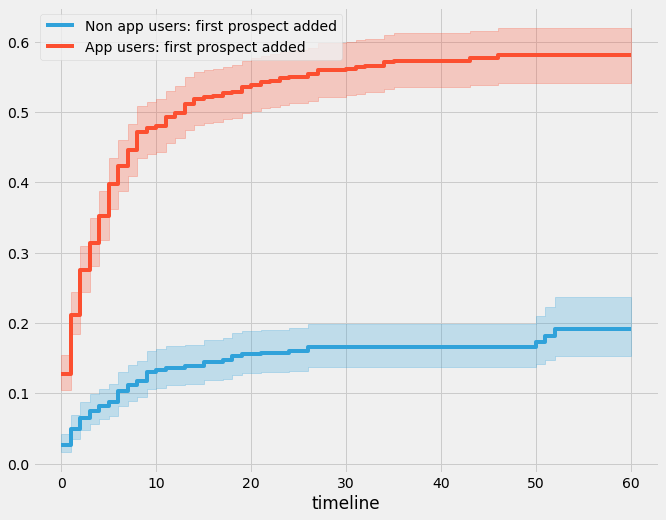

In [236]:
fit_cumulative_density_plot(non_app_df,'tenure first prospect added','has first prospect added','Non app users:')
fit_cumulative_density_plot(app_df,'tenure first prospect added','has first prospect added','App users:')

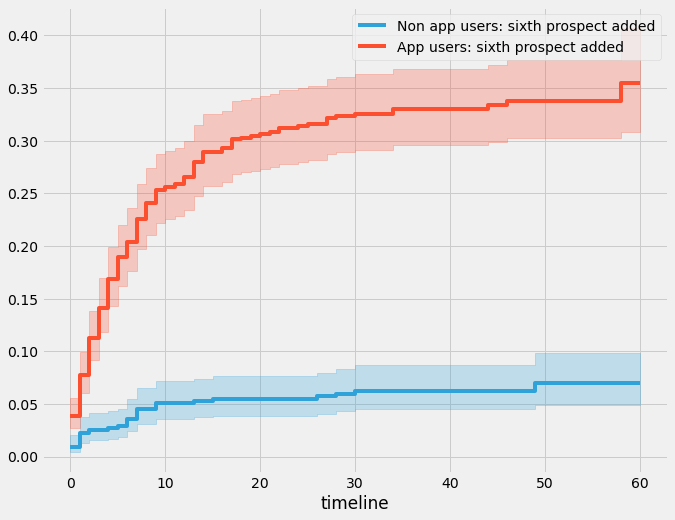

In [237]:
fit_cumulative_density_plot(non_app_df,'tenure sixth prospect added','has sixth prospect added','Non app users:')
fit_cumulative_density_plot(app_df,'tenure sixth prospect added','has sixth prospect added','App users:')

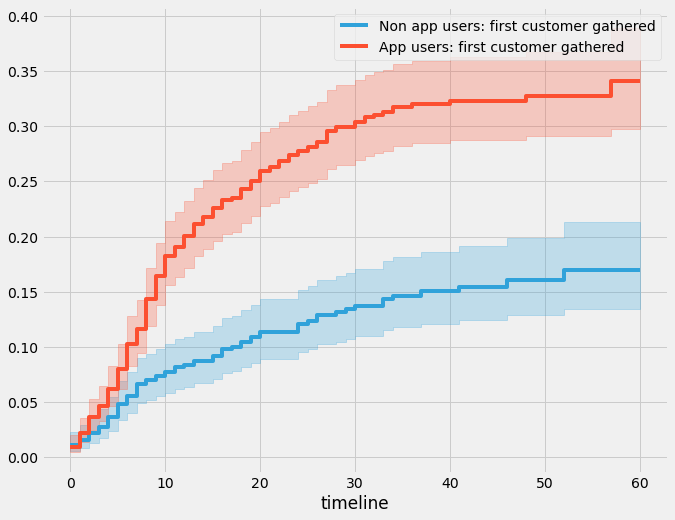

In [238]:
fit_cumulative_density_plot(non_app_df,'tenure first customer gathered','has first customer gathered','Non app users:')
fit_cumulative_density_plot(app_df,'tenure first customer gathered','has first customer gathered','App users:')


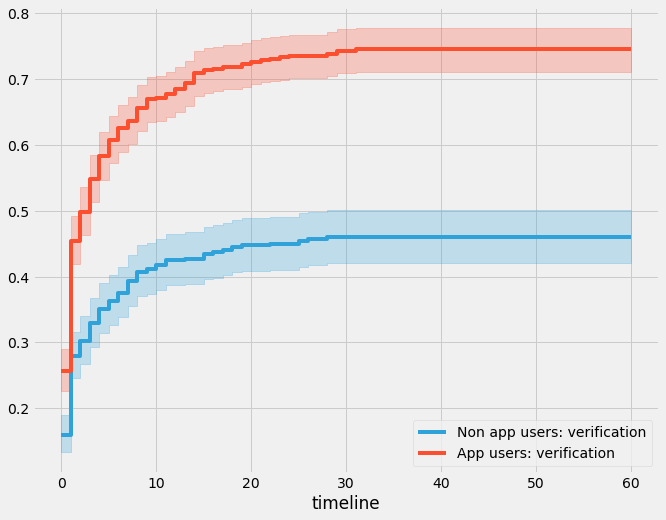

In [239]:
fit_cumulative_density_plot(non_app_df,'tenure verification','has verification','Non app users:')
fit_cumulative_density_plot(app_df,'tenure verification','has verification','App users:')


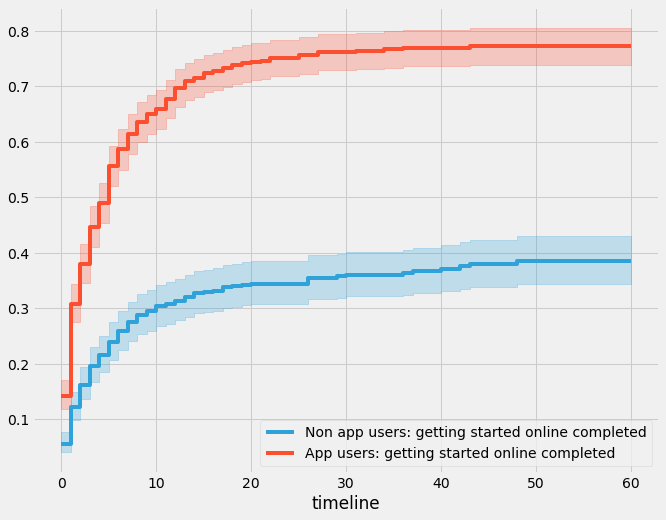

In [240]:
fit_cumulative_density_plot(non_app_df,'tenure getting started online completed','has getting started online completed','Non app users:')
fit_cumulative_density_plot(app_df,'tenure getting started online completed','has getting started online completed','App users:')

In [209]:
non_app_df.shape,app_df.shape

((1681, 20), (722, 20))

In [380]:
## Volume comparison
[1049,250,216,18]

[1049, 250, 216, 18]